In [389]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA



In [390]:
#read file
df = pd.read_csv("merge_month_freqency.csv")

In [391]:
#check the data
print(df.head())

     month  frequency
0  2016-01      11316
1  2016-02      10233
2  2016-03      11832
3  2016-04      11772
4  2016-05      11895


In [392]:
#convert month to data object
df['month'] = pd.to_datetime(df['month'],format='%Y-%m')
print(df.head())

       month  frequency
0 2016-01-01      11316
1 2016-02-01      10233
2 2016-03-01      11832
3 2016-04-01      11772
4 2016-05-01      11895


In [393]:
#convert month column to index
df.set_index('month', inplace=True)

In [394]:
#check data
print(df.head())

            frequency
month                
2016-01-01      11316
2016-02-01      10233
2016-03-01      11832
2016-04-01      11772
2016-05-01      11895


Text(0.5, 0, 'Year')

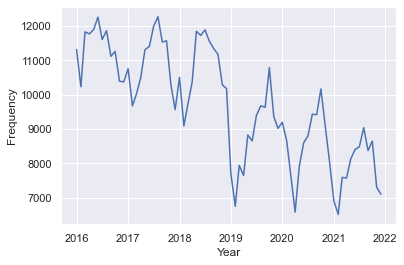

In [395]:
#generate a time series plot
sns.lineplot(data=df,x="month",y = "frequency")

plt.ylabel("Frequency")
plt.xlabel("Year")

In [396]:
#check stationarity
#calculate 7 month rolling mean and sd
rolling_mean = df.rolling(window=7).mean()
rolling_std = df.rolling(window=7).std()

Text(0.5, 1.0, 'Crime Data Time Series, Rolling Mean and Standard Deviation')

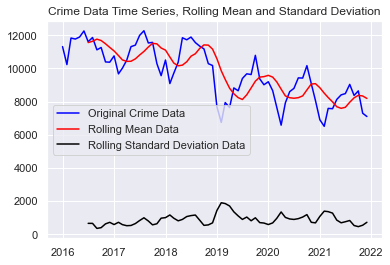

In [397]:
#overlay our time series with rolling mean and sd
#first make a Matplotlib plot of our time series
plt.plot(df, color='blue',label='Original Crime Data')
#add rolling mean and sd
plt.plot(rolling_mean, color="red", label="Rolling Mean Data")
#add rolling  sd
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation Data")
plt.legend(loc="best")
plt.title("Crime Data Time Series, Rolling Mean and Standard Deviation")

In [398]:
#pass our data frame into the adfuller method, we specify the autolag parameter as "AIC",
#which means that the lag is chosen to minimize the information criterion
adft = adfuller(df, autolag='AIC')


In [399]:
#store our results in a data frame\
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -0.588200              Test Statistics
1   0.873626                      p-value
2   8.000000             No. of lags used
3  63.000000  Number of observations used
4  -3.538695          critical value (1%)
5  -2.908645          critical value (5%)
6  -2.591897         critical value (10%)


In [400]:
#since the p-value is greather than 5% and test statistics is greater than critical value, 
# we can say that the data is not stationary
# We need check correlation and make autocorrelation
autocorrelation_lag1 = df['frequency'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df['frequency'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['frequency'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['frequency'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

#we can see our data is pretty correlated in short term



One Month Lag:  0.8721758345872244
Three Month Lag:  0.6028104363310689
Six Month Lag:  0.24971347295650256
Nine Month Lag:  0.46336168857915766


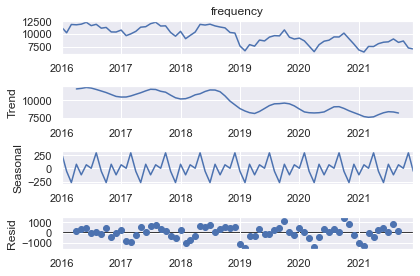

In [401]:
decompose = seasonal_decompose(df['frequency'],model='additive', period=7)
decompose.plot()
plt.show()


/var/folders/fr/0_7xr4pj1yb9zdvs7vk07dd80000gn/T/ipykernel_1192/1083026704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['frequency']
/var/folders/fr/0_7xr4pj1yb9zdvs7vk07dd80000gn/T/ipykernel_1192/1083026704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['frequency']


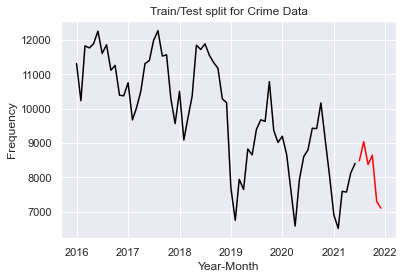

In [402]:
#split train and test and visualize the split
df['month'] = df.index
train = df[df['month'] < pd.to_datetime("2021-7", format='%Y-%m')]
train['train'] = train['frequency']
del train['month']
del train['frequency']
test = df[df['month'] >= pd.to_datetime("2021-7", format='%Y-%m')]
del test['month']
test['test'] = test['frequency']
del test['frequency']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Crime Data")
plt.ylabel("Frequency")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [403]:
test

,test
month,
2021-07-01,8481
2021-08-01,9036
2021-09-01,8370
2021-10-01,8643
2021-11-01,7296
2021-12-01,7098


In [404]:
model = auto_arima(train, start_p=0, d=None, start_q=0,
max_p=5,max_d=5,max_q=5,start_P=0,
D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=12,seasonal=True,
error_action="warn",trace=True,surpress_warnings=True,stepwise=True,
random_state=20,n_fits=50)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=912.893, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=898.633, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=897.074, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=927.889, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=894.658, Time=0.08 sec


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=895.294, Time=0.56 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=896.641, Time=0.10 sec


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=896.644, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=898.384, Time=0.08 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=898.276, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=905.735, Time=0.11 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12] intercept
Total fit time: 3.189 seconds


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


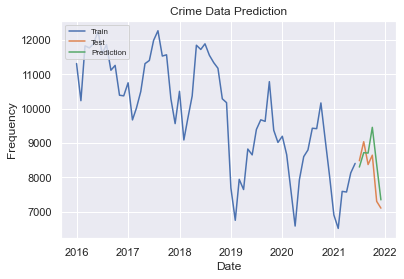

In [405]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Crime Data Prediction')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [406]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  594.0286009771747


In [407]:
from sklearn.metrics import r2_score
r2_score(test["test"],forecast["Prediction"])



0.2993815632150988

In [408]:
#predict future
#
future_df = pd.date_range('2022-01-01','2022-06-01')
future_df = pd.DataFrame(index=future_df)
future_df


""
2022-01-01
2022-01-02
2022-01-03
2022-01-04
2022-01-05
...
2022-05-28
2022-05-29
2022-05-30
2022-05-31


In [409]:
future = model.predict(n_periods=len(future_df))
future_df['Frequency'] = future
future_df

,Frequency
2022-01-01,8297.390259
2022-01-02,8717.066335
2022-01-03,8705.066335
2022-01-04,9455.066335
2022-01-05,8369.066335
...,...
2022-05-28,911.862361
2022-05-29,-174.137639
2022-05-30,-1203.137639
2022-05-31,-2355.137639


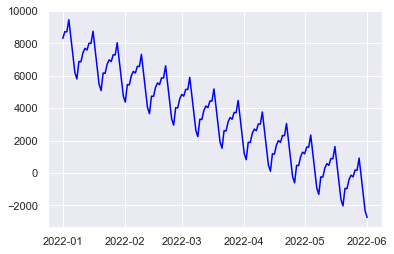

In [410]:
plt.plot(future_df, color='blue',label='Original Crime Data')


